### Set Up

#### Standard library imports

In [1]:
import copy
import datetime
import math
import os
import pdb
import random
import time

#### Third party imports 

In [2]:
import pydot
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

#### Local imports

In [3]:
import modules.batch as batch
import modules.midi_related as midi
import modules.preprocessing as prep
import modules.subclasses as sub

#### Extensions and autoreload

In [4]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

#### Dis-/enable GPU

In [5]:
disable_gpu = False
debugging = False

if disable_gpu:
    # Hide GPU from visible devices
    tf.config.set_visible_devices([], 'GPU')
    if debugging:
        # To find out which devices your operations and tensors are assigned to
        tf.debugging.set_log_device_placement(True)

        # Create some tensors and perform an operation
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)

        print(c)
        tf.debugging.set_log_device_placement(False)

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')

#### Setting relative directories

In [7]:
Working_Directory = os.getcwd()
Project_Directory = os.path.abspath(os.path.join(Working_Directory,'..'))
Music_In_Directory = Project_Directory + "/data/" 
Output_Directory = Project_Directory + "/outputs/"
Model_Directory = Output_Directory + "models/"
Checkpoint_Directory = Model_Directory + "ckpt/"
Numpy_Directory = Model_Directory + "arrays/"
Music_Out_Directory = Output_Directory + "midi/"
Music_Out_Training_Directory =  Music_Out_Directory + "train/"
Music_Out_Genereating_Directory = Music_Out_Directory + "generated/"

Midi_Directories = [
    #"albeniz", 
    #"beeth",
    #"borodin",
    #"brahms",
    #"burgm",
    #"chopin", 
    "chopin_midi",
    #"debussy", 
    #"granados", 
    #"grieg", 
    #"haydn", 
    #"liszt", 
    #"mendelssohn", 
    #"mozart", 
    #"muss", 
    #"schubert", 
    #"schumann", 
    "tschai"
] 

### Data preperation

#### Load pieces (i.e. import midi files)

In [8]:
# First checkt that importing single midi (i.e. Chopin Op 28 No.4) works
chop2804 = midi.midiToNoteStateMatrix(Music_In_Directory + "chopin_midi/chop7201.mid") 

In [9]:
# Import all Midi data
min_time_steps = 128 # only files with at least this many 48th note steps are saved
lowerBound = 21
upperBound = 109

all_pieces = {}
chopin_only_pieces = {}
piano_midi_only_pieces = {}

start_time_loading = time.time()
time_loading_old = start_time_loading

# Gather the pieces from the specified directory
for f in range(len(Midi_Directories)):
    Training_Midi_Folder = Music_In_Directory + Midi_Directories[f]
    if Midi_Directories[f] == 'chopin_midi':
        chopin_only_pieces = {**chopin_only_pieces, **midi.loadPieces(Training_Midi_Folder,
                                                                      min_time_steps,
                                                                      lowerBound, 
                                                                      upperBound,
                                                                      verbose=False,
                                                                      verbose_name=True)}
    else: 
        piano_midi_only_pieces = {**piano_midi_only_pieces, **midi.loadPieces(Training_Midi_Folder,
                                                                              min_time_steps,
                                                                              lowerBound, 
                                                                              upperBound,
                                                                              verbose=False,
                                                                              verbose_name=True)}
    time_loading_new = time.time()
    duration = time_loading_new - time_loading_old
    time_loading_old = time_loading_new
    print('Loading directory ' + Midi_Directories[f] + ' took ' + str(round(duration, 3)) + 's' )

all_pieces = {**chopin_only_pieces, **piano_midi_only_pieces}
end_time_loading = time.time()

print('Number of total pieces = ', len(all_pieces))    
print('Loading all pieces took ' +  str(round(end_time_loading - start_time_loading, 3)) + 's')

Loaded chop0601
Loaded chop0602
Loaded chop0603
Loaded chop0701
Loaded chop0702
Loaded chop0901
Loaded chop0902
Loaded chop0903
Loaded chop1001
Loaded chop1002
Loaded chop1003
Loaded chop1004
Loaded chop1005
Loaded chop1007
Loaded chop1012
Loaded chop1501
Loaded chop1502
Loaded chop1503
Loaded chop1800
Loaded chop2300
Loaded chop2501
Loaded chop2502
Loaded chop2503
Loaded chop2504
Loaded chop2506
Loaded chop2507
Loaded chop2511
Loaded chop2512
Loaded chop2701
Loaded chop2702
Loaded chop2801
Loaded chop2802
Loaded chop2803
Loaded chop2804
Loaded chop2805
Loaded chop2806
Loaded chop2807
Loaded chop2808
Loaded chop2809
Loaded chop2810
Loaded chop2811
Loaded chop2812
Loaded chop2813
Loaded chop2814
Loaded chop2815
Loaded chop2816
Loaded chop2817
Loaded chop2818
Loaded chop2819
Loaded chop2820
Loaded chop2821
Loaded chop2822
Loaded chop2823
Loaded chop2824
Loaded chop3002
Loaded chop3100
Loaded chop3202
Loaded chop3302
Loaded chop3304
Loaded chop3402
Loaded chop3502
Loaded chop3503
Loaded c

#### Chopin pieces by genre

In [10]:
print('Number of Chopin pieces loaded = ', len(chopin_only_pieces))

Number of Chopin pieces loaded =  95


In [11]:
#Only include pieces which were not recoreded (i.e. which MIDI files are exact) and are in 2/4, 3/4 or 4/4
time_signatures = []
verbose = False #True
chopin_pieces_exact = chopin_only_pieces.copy()
keys = list(chopin_pieces_exact.keys())
for k in keys:
        piece = chopin_pieces_exact[str(k)]
        time_signature = max([b[0][3] for b in  piece])
        if not (str(k) in midi.EXACT_FILES):
            chopin_pieces_exact.pop(k)
        else:
            time_signatures.append(time_signature)
        if verbose:
            print("Piece: {}".format(k) + "  Time signature: {}".format(time_signature))
time_signatures = np.array(time_signatures)
unique, counts = np.unique(time_signatures, return_counts=True)
dict(zip(unique, counts))

{4: 1, 6: 3, 8: 2, 12: 37, 16: 31, 17: 1, 19: 1, 24: 6, 28: 1, 36: 1, 40: 1}

In [12]:
# Create table of piece names for midi files loaded
df_chopin_opus = pd.read_csv(Project_Directory + '/data_info/chopin_title_opus.csv')
op_numbers = [int(str(k)[4:6]) for k in chopin_pieces_exact.keys()]
op_numbers_unique = set(op_numbers)
df_chopin_opus_midi = df_chopin_opus.loc[df_chopin_opus['Op'].isin(op_numbers_unique)]

In [13]:
# Define genres
genres = [
    'Ballade', 
    'Etudes', 
    'promptu', 
    'Mazurkas', 
    'Nocturne', 
    'Preludes',  
    'Sonata', 
    'Waltz',
    'Polonaise',
    'Scherzo',
    'Marche funèbre',
    'Ecossaises'
]
def agg_op(x):
    pdb.set_trace()
    list(x)
    
def aggregate(data):
    d = {}
    Op_list = data['Op'].tolist()
    Midi_list = data['MIDI files'].tolist()
    d['Op'] = [ str(a) + ' (' + str(b) + ')' for a, b in zip(Op_list, Midi_list)]
    d['MIDI files'] = sum(data['MIDI files'])
    return pd.Series(d)

df_pieces_summary = pd.concat([midi.get_piece_summary_df(i, df_chopin_opus_midi, op_numbers) for i in genres])
df_genre_summary = df_pieces_summary[['MIDI files', 'genre', 'Op']] \
                    .groupby(['genre']) \
                    .apply(aggregate)
df_genre_summary.rename(index={'Ballade':'Ballades','promptu':'Impromptus', 'Sonata' : 'Sonatas', 'Nocturne' : 'Nocturnes', 'Waltz' :'Waltzes'}, inplace=True)
df_genre_summary = df_genre_summary.sort_index()
df_genre_summary.style.set_properties(subset=['Op'], **{'width-min': '300px'})

,Op,MIDI files
genre,,
Ballades,"['23 (1)', '38 (1)', '47 (1)', '52 (1)']",4
Ecossaises,['72 (1)'],1
Etudes,"['10 (7)', '25 (7)']",14
Impromptus,['66 (1)'],1
Marche funèbre,['72 (1)'],1
Mazurkas,"['6 (3)', '7 (2)', '30 (1)', '33 (2)', '67 (3)', '68 (1)']",12
Nocturnes,"['9 (3)', '15 (3)', '27 (2)', '32 (1)', '37 (2)', '48 (2)', '55 (2)', '62 (1)', '72 (1)']",17
Polonaise,"['40 (2)', '53 (1)']",3
Preludes,['28 (24)'],24


In [14]:
# Update all_pieces to only use pieces from defined genres 
op_train = [item for sublist in df_genre_summary['Op'] for item in sublist]
genere_keys = [k for k in chopin_only_pieces.keys() if int(str(k)[4:6]) in op_train]
genere_pieces = {k:v for k, v in chopin_only_pieces.items() if k in genere_keys}
print('Number of pieces by Chopin left for selected generes = ', len(genere_pieces))

Number of pieces by Chopin left for selected generes =  0


In [15]:
# Define pieces for each genre
ballades = midi.get_subset_all_pieces_for_genre('Ballades', chopin_only_pieces, df_genre_summary)
etudes = midi.get_subset_all_pieces_for_genre('Etudes', chopin_only_pieces, df_genre_summary)
impromptus = midi.get_subset_all_pieces_for_genre('Impromptus', chopin_only_pieces, df_genre_summary)
mazurkas = midi.get_subset_all_pieces_for_genre('Mazurkas', chopin_only_pieces, df_genre_summary)
nocturnes = midi.get_subset_all_pieces_for_genre('Nocturnes', chopin_only_pieces, df_genre_summary)
preludes = midi.get_subset_all_pieces_for_genre('Preludes', chopin_only_pieces, df_genre_summary)
sonatas = midi.get_subset_all_pieces_for_genre('Sonatas', chopin_only_pieces, df_genre_summary)
waltzes = midi.get_subset_all_pieces_for_genre('Waltzes', chopin_only_pieces, df_genre_summary)

#### Filter 'incorrect' Chopin pieces by genre

In [16]:
#Check time signature occurences
time_signatures = []
verbose = False #True
keys = list(chopin_only_pieces.keys())
for k in keys:
    piece = chopin_only_pieces[str(k)]
    time_signature = max([b[0][3] for b in  piece])
    if str(k) in midi.EXACT_FILES:
        time_signatures.append(time_signature)
    if verbose:
        print("Piece: {}".format(k) + "  Time signature: {}".format(time_signature))
time_signatures = np.array(time_signatures)
unique, counts = np.unique(time_signatures, return_counts=True)
dict(zip(unique, counts))

{4: 1, 6: 3, 8: 2, 12: 37, 16: 31, 17: 1, 19: 1, 24: 6, 28: 1, 36: 1, 40: 1}

In [17]:
print('Number of synthesized Chopin pieces = ', sum(counts))

Number of synthesized Chopin pieces =  85


In [18]:
import matplotlib.pyplot as plt
time_signatures_dict = dict()
time_signatures_dict["other"] =  0
keys = [
    "3/8",
    "4/8\n 2/4",
    "6/8\n 3/4",
    "8/8\n 4/4",
    "12/8\n 6/4",
    "other"
]

for ts in zip(unique, counts):
    if ts[0] == 6:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[0]] = ts[1]
    elif ts[0] == 8:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[1]] = ts[1]
    elif ts[0] == 12:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[2]] = ts[1]
    elif ts[0] == 16:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[3]] = ts[1]
    elif ts[0] == 24:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[4]] = ts[1]
    else:
        # create a new array in this slot
        time_signatures_dict[keys[5]] += ts[1]
        
desired_order_list = [1, 2, 3, 4, 5, 6]

time_signatures_dict = {keys[k-1]: time_signatures_dict[keys[k-1]] for k in desired_order_list}

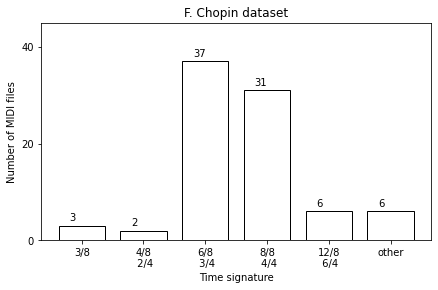

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

x_tmp = time_signatures_dict.keys()
y_tmp = time_signatures_dict.values()

fig, ax = plt.subplots()
fig.set_facecolor('white')
width = 0.75 # the width of the bars 
ax.bar(x_tmp, y_tmp, width, color="black", fill=False)
plt.title('F. Chopin dataset')
plt.xlabel('Time signature')
plt.ylabel('Number of MIDI files')   
plt.ylim([0, 45])
for i, v in enumerate(y_tmp):
    ax.text(i -0.2, v + 1 , str(v), color='black')
    
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.rcParams.update({'font.size': 22})
plt.savefig(os.path.join('Chopin_dataset.png'), dpi=300, format='png', bbox_inches='tight', transparent= False)

In [22]:
#Only include pieces which were not recoreded (i.e. which MIDI files are exact) and are in 2/4, 3/4 or 4/4
time_signatures = []
verbose = False #True
chopin_pieces_filtered = chopin_only_pieces.copy()
keys = list(chopin_pieces_filtered.keys())
for k in keys:
        piece = chopin_pieces_filtered[str(k)]
        time_signature = max([b[0][3] for b in  piece])
        if not ((time_signature in [16]) and str(k) in midi.EXACT_FILES) :
            chopin_pieces_filtered.pop(k)
        else:
            time_signatures.append(time_signature)
        if verbose:
            print("Piece: {}".format(k) + "  Time signature: {}".format(time_signature))
time_signatures = np.array(time_signatures)
unique, counts = np.unique(time_signatures, return_counts=True)
dict(zip(unique, counts))

{16: 31}

In [23]:
print('Number of Chopin pieces left after filtering = ', len(chopin_pieces_filtered))

Number of Chopin pieces left after filtering =  31


#### Filter Piano Midi pieces by 3/4 or 4/4 measure

In [24]:
print('Number of Piano Midi pieces loaded = ', len(piano_midi_only_pieces))

Number of Piano Midi pieces loaded =  12


In [25]:
#Check time signature occurences
time_signatures = []
verbose = False #True
keys = list(piano_midi_only_pieces.keys())
for k in keys:
    piece = piano_midi_only_pieces[str(k)]
    time_signature = max([b[0][3] for b in  piece])
    time_signatures.append(time_signature)
    if verbose:
        print("Piece: {}".format(k) + "  Time signature: {}".format(time_signature))
time_signatures = np.array(time_signatures)
unique, counts = np.unique(time_signatures, return_counts=True)
dict(zip(unique, counts))

{8: 2, 12: 4, 16: 5, 18: 1}

In [26]:
import matplotlib.pyplot as plt
time_signatures_dict = dict()
time_signatures_dict["other"] =  0
keys = [
    "3/8",
    "4/8\n 2/4",
    "6/8\n 3/4",
    "8/8\n 4/4",
    "12/8\n 6/4",
    "other"
]

for ts in zip(unique, counts):
    if ts[0] == 6:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[0]] = ts[1]
    elif ts[0] == 8:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[1]] = ts[1]
    elif ts[0] == 12:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[2]] = ts[1]
    elif ts[0] == 16:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[3]] = ts[1]
    elif ts[0] == 24:
        # append the new number to the existing array at this slot
        time_signatures_dict[keys[4]] = ts[1]
    else:
        # create a new array in this slot
        time_signatures_dict[keys[5]] += ts[1]
        
desired_order_list = [1, 2, 3, 4, 5, 6]

time_signatures_dict = {keys[k-1]: time_signatures_dict[keys[k-1]] for k in desired_order_list}

KeyError: '3/8'

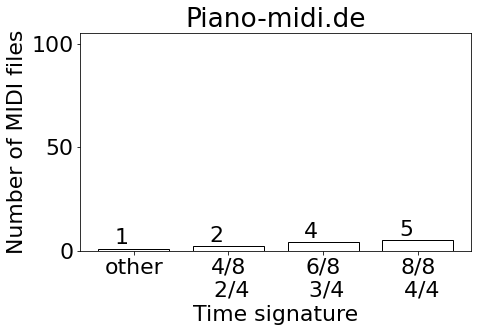

In [27]:
import matplotlib.pyplot as plt

x_tmp = time_signatures_dict.keys()
y_tmp = time_signatures_dict.values()

fig, ax = plt.subplots()
fig.set_facecolor('white')
width = 0.75 # the width of the bars 
ax.bar(x_tmp, y_tmp, width, color="black", fill=False)
plt.title('Piano-midi.de')
plt.xlabel('Time signature')
plt.ylabel('Number of MIDI files')   
plt.ylim([0, 105])
for i, v in enumerate(y_tmp):
    ax.text(i - 0.2 , v + 2 , str(v), color='black')

fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.rcParams.update({'font.size': 22})
plt.savefig(os.path.join('Piano_midi.png'), dpi=300, format='png', bbox_inches='tight', transparent= False)

In [28]:
#order training pieces by time signature
piano_midi_pieces_filtered = piano_midi_only_pieces.copy()
piano_midi_pieces_remaining = piano_midi_only_pieces.copy()
keys = list(piano_midi_only_pieces.keys())
verbose = False

for k in keys:
    piece = piano_midi_only_pieces[str(k)]
    time_signature = int(max([b[0][3] for b in  piece]))
    if not (time_signature in [16]):
        piano_midi_pieces_filtered.pop(k)
    else:
        piano_midi_pieces_remaining.pop(k)
    if verbose:
        print("Piece: {}".format(k) + "  Time signature: {}".format(time_signature))

In [29]:
print('Number of Piano Midi pieces left after filtering = ', len(piano_midi_pieces_filtered))

Number of Piano Midi pieces left after filtering =  5


#### Train/Validation pieces split

In [31]:
# Define pieces relevant for training and validation
#pieces_tmp = piano_midi_pieces_filtered.copy()
pieces_tmp = chopin_pieces_filtered.copy()

In [32]:
# Free up memory
def free_memory():
    all_pieces.clear()
    chopin_only_pieces.clear()
    genere_pieces.clear()
    piano_midi_only_pieces.clear()
    piano_midi_pieces_filtered.clear()
    piano_midi_pieces_remaining.clear()
    pieces_tmp.clear()

In [33]:
# Either select one validation and one training piece or 
# set aside a random set of pieces for validation purposes
n_subset = 30
#selection = 'single_piece' 
#selection = 'subset'
selection = 'all'

random.seed(1337)
if selection == 'single_piece':
    validation_pieces = copy.deepcopy({'chop2803' : all_pieces['chop2803']})
    training_pieces   = copy.deepcopy({'chop2804' : all_pieces['chop2804']})
    free_memory()
elif selection == 'subset' or selection == 'all':
    if selection == 'subset':
        training_pieces = copy.deepcopy({k: pieces_tmp[k] for k in random.sample(list(pieces_tmp.keys()), n_subset)})
        free_memory()
    elif selection == 'all':
        training_pieces = pieces_tmp.copy()
    num_validation_pieces = len(training_pieces) // 10

    validation_pieces={}
    for v in range(num_validation_pieces):
        index = random.choice(list(training_pieces.keys()))
        validation_pieces[index] = training_pieces.pop(index)

In [34]:
print('Number of training   pieces = ', len(training_pieces))    
print('Number of validation pieces = ', len(validation_pieces))     

Number of training   pieces =  28
Number of validation pieces =  3


#### Check that features (X) and lables (y) generation work

In [35]:
# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
y = batch.getPieceBatch(training_pieces, batch_size = 2, num_time_steps = 96) 
X = prep.inputKernel(y, Midi_low = 21, Midi_high = 108)


print('Dimensions y: (sample_size, num_notes, num_timesteps, play_articulate_velocity) = ', y.shape)
print('Dimensions X: (sample_size, num_notes, num_timesteps, feature_dim             ) = ', X.shape)

Dimensions y: (sample_size, num_notes, num_timesteps, play_articulate_velocity) =  (2, 88, 96, 4)
Dimensions X: (sample_size, num_notes, num_timesteps, feature_dim             ) =  (2, 88, 96, 108)


In [33]:
# Feature vector for the 1st batch the 31rd note and the 51st 48th-note timestep (cast to int)
prep.noteRNNInputSummary(X[0,46,3,:])

{'note': 67,
 'pitch_class': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'part_prev_vicinity': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'part_prev_vicinity_lower': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'part_prev_vicinity_same': array([0, 0, 0]),
 'part_prev_vicinity_higher': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'part_context': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'beat': array([1, 0, 0, 0, 0]),
 'time_signature': 16,
 'velocity': 0,
 'zero': 0}

In [36]:
# Compare to all notes played at timestep 51
[(i,j) for i,j in enumerate(list(tf.cast(y[0,:,0,:], dtype=tf.int32).numpy())) if j[0]== 1]

[(23, array([ 1,  1, 32,  1], dtype=int32)),
 (30, array([ 1,  1, 36,  1], dtype=int32)),
 (35, array([ 1,  1, 40,  1], dtype=int32)),
 (39, array([ 1,  1, 52,  1], dtype=int32))]

#### Test generating midi files from y_train 

In [37]:
# Backtransform the 128 48th notes from the first random sampled training_piece to MIDI
test_midi = tf.cast(tf.transpose(y, perm=[0,2,1,3])[0,:,:,:], dtype=tf.int32).numpy()
midi.noteStateMatrixToMidi(test_midi, Music_Out_Directory + "random_test")

#### Check number of notes played, articulated and velocity per timestep

In [38]:
test = tf.transpose(y, perm=[0,2,1,3])[0,:,:,:].numpy()
notes_per_timestep = [(i,tf.reduce_sum(test[i,:,0]).numpy()) for i in range(test.shape[0])]
articulate_per_timestep = [(i,tf.reduce_sum(test[i,:,1]).numpy()) for i in range(test.shape[0])]
mean_tempo_per_timestep = [(i,tf.reduce_mean(test[i,np.array(test[i,:,0], dtype=bool),2]).numpy()) for i in range(test.shape[0])]

### Model architecture

#### Parameters

In [39]:
Midi_low = lowerBound
Midi_high = upperBound - 1
num_notes = Midi_high + 1 - Midi_low # X.shape[1] = Midi_high + 1 - Midi_low 
num_timesteps = -1 # keep the num_timesteps variable, in training set to X.shape[2]
input_size = 108 # X.shape[3]
drop_out_rate = 0.5

num_t_units = [128, 128] # [256, 128]
num_n_units = [64,  64] # [128,  64]
dense_units = 3    # (play,articulate,velocity)

TIME_BATCH_SHAPE = (num_timesteps, input_size)
NOTE_BATCH_SHAPE = (num_notes, num_t_units[1])

#### Inputs

In [40]:
inputs = tf.keras.Input(shape=(num_notes, None, input_size), name="inputs")
inputs_shape = sub.GetShape()(inputs)

#### Timewise LSTM

In [41]:
# Reshaping
x = sub.BatchReshape(TIME_BATCH_SHAPE, False)(inputs)

# Timewise LSTMs
x = tf.keras.layers.LSTM(num_t_units[0], return_sequences=True, dropout= drop_out_rate)(x)
x = tf.keras.layers.LSTM(num_t_units[1], return_sequences=True, dropout= drop_out_rate)(x)

#### Notewise LSTM

In [42]:
# Reshaping
x = sub.BatchReshape([num_notes, num_timesteps , num_t_units[1]], True)(x)
x = tf.keras.layers.Permute((2,1,3))(x)
x = sub.BatchReshape(NOTE_BATCH_SHAPE, False)(x)

# Notewise LSTMs
x = tf.keras.layers.LSTM(num_n_units[0], return_sequences=True, dropout= drop_out_rate)(x)
x = tf.keras.layers.LSTM(num_n_units[1], return_sequences=True, dropout= drop_out_rate)(x)

#### Simulate conditional probabilty using dense layers

In [43]:
x = sub.SliceNotesTensor()(x)

x_tmp = tf.keras.layers.Dense(units=dense_units, activation=None)(x[0])
note = sub.SampleNote()(x_tmp)

x_list = [x_tmp]
note_list = [sub.SliceNoteVelocityTensor()(note)]

for n in range(1,len(x)):
    x_tmp = tf.keras.layers.Concatenate(axis=-1)([x[n], note])
    x_tmp = tf.keras.layers.Dense(units=dense_units, activation=None)(x_tmp)
    note = sub.SampleNote()(x_tmp)
    x_list.append(x_tmp)
    note_list.append(sub.SliceNoteVelocityTensor()(note))

#### Outputs

In [44]:
# Output 1    
x_list = sub.ExpandDims()(x_list, axis=1)
x = tf.keras.layers.Concatenate(axis=1)(x_list)
x = sub.BatchReshape([num_timesteps, num_notes , dense_units], True)(x, inputs_shape)
x_1, x_2 = sub.SliceNotesVelocityTensor()(x)
output_1 = tf.keras.layers.Permute((2,1,3), name='play_articulate_prob')(x_1)

#Output 2
x_2 = sub.BackTransformVelocity()(x_2)
output_2 = tf.keras.layers.Permute((2,1,3), name='velocity')(x_2)

# Output 3
note_list = sub.ExpandDims()(note_list, axis=1)
note = tf.keras.layers.Concatenate(axis=1)(note_list)
note = sub.BatchReshape([num_timesteps, num_notes , 2], True)(note, inputs_shape)
output_3 = tf.keras.layers.Permute((2,1,3), name='play_articulate_sampled')(note)

#### Full LSTM

In [45]:
lstm = tf.keras.Model(inputs, [output_1, output_2, output_3], name="full")
lstm.summary()

Model: "full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 88, None, 10 0                                            
__________________________________________________________________________________________________
batch_reshape (BatchReshape)    (None, None, 108)    0           inputs[0][0]                     
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    121344      batch_reshape[0][0]              
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 128)    131584      lstm[0][0]                       
_______________________________________________________________________________________________

In [46]:
plot = False
if plot:
    plot_res = tf.keras.utils.plot_model(lstm, to_file="model.svg")

### Model training

In [53]:
# Reload alread trained model 
reload = True
if reload:
    Date = "20210920"
    name = "alpha_0.01_beta_1.0_epoch_64_model"
    load_path = Checkpoint_Directory + Date + "/" + name
    lstm = tf.keras.models.load_model(load_path)

In [54]:
# loss
losses = (sub.CustomSigmoidFocalCrossEntropy(from_logits = True, 
                                           gamma = 0, 
                                           alpha = 0),
          sub.MeanSquaredErrorVelocity())

# metric
metrics = (sub.CustomBinaryAccuracy(threshold=0.5), 
           tfa.metrics.MultiLabelConfusionMatrix(num_classes=2),
           sub.root_mean_squared_error_velocity_metric)

# optimizer
optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, epsilon=1e-04)

In [55]:
### The tf.function 
@tf.function(experimental_relax_shapes=True)
def train_on_batch(X, y, alpha, beta):
    
    with tf.GradientTape() as tape:
        
        y_pred_p_a, y_pred_velocity, sampled_p_a = lstm(X, training=True)
        
        loss_p_a        = losses[0](y, y_pred_p_a)
        loss_velocity   = losses[1](y, y_pred_velocity)
        loss_total      = beta * loss_p_a + alpha * tf.math.sqrt(loss_velocity) / 127 
                
        metric_p_a      = metrics[0](y, y_pred_p_a)
        confs           = metrics[1](tf.reshape(y[:,:,:,0:2],  [-1,2]), 
                                    tf.reshape(sampled_p_a, [-1,2]))
        p_conf, a_conf  = confs[0], confs[1]
        metric_velocity = metrics[2](y, y_pred_velocity)
        

    grads = tape.gradient(loss_total, lstm.trainable_weights)
    optimizer.apply_gradients(zip(grads, lstm.trainable_weights))

    return (loss_p_a, 
            tf.math.sqrt(loss_velocity), 
            tf.reduce_mean(metric_p_a), 
            tf.reduce_mean(metric_velocity), 
            [p_conf, a_conf])

@tf.function(experimental_relax_shapes=True)
def validate_on_batch(X, y, alpha):
    
    y_pred_p_a, y_pred_velocity, sampled_p_a = lstm(X, training=False)
    
    loss_p_a       = losses[0](y, y_pred_p_a)
    loss_velocity  = losses[1](y, y_pred_velocity)
    
    metric_p_a     = metrics[0](y, y_pred_p_a)
    confs          = metrics[1](tf.reshape(y[:,:,:,0:2],  [-1,2]), 
                                tf.reshape(sampled_p_a, [-1,2]))
    p_conf, a_conf = confs[0], confs[1]    
    metric_velocity = metrics[2](y, y_pred_velocity)
    
    return (loss_p_a, 
            tf.math.sqrt(loss_velocity),
            tf.reduce_mean(metric_p_a), 
            tf.reduce_mean(metric_velocity), 
            [p_conf, a_conf])

In [56]:
current_time_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

epochs = 64 
batch_size = 2
epoch_save_list = [1, 2, 4, 8, 16, 32, 64] #Checkpoint_Directory
alpha = tf.constant(1/100)
beta = tf.constant(1.)

n_train_batches = prep.getNumberOfBatches(training_pieces, batch_size)
n_val_batches = prep.getNumberOfBatches(validation_pieces, batch_size)

# Values for loss, metric and confusion matrix
train_loss_p_a_array   = np.full((epochs, n_train_batches), 10.0)
train_loss_vel_array   = np.full((epochs, n_train_batches), 10.0)
train_metric_p_a_array = np.full((epochs, n_train_batches), 10.0)
train_metric_vel_array = np.full((epochs, n_train_batches), 10.0)
val_loss_p_a_array     = np.full((epochs, n_val_batches), 10.0)
val_loss_vel_array     = np.full((epochs, n_val_batches), 10.0)
val_metric_p_a_array   = np.full((epochs, n_val_batches), 10.0)
val_metric_vel_array   = np.full((epochs, n_val_batches), 10.0)
train_p_conf_array     = np.full((epochs, 2, 2), 10.0)
train_a_conf_array     = np.full((epochs, 2, 2), 10.0)
val_p_conf_array       = np.full((epochs, 2, 2), 10.0)
val_a_conf_array       = np.full((epochs, 2, 2), 10.0)

In [57]:
(n_train_batches, n_val_batches)

(889, 56)

In [58]:
### CUSTOM TRAINING LOOP

# Timing
start_time = time.time()
time_old = start_time

for epoch in range(epochs):
    print('\rStart of Epoch [%d/%d]'% (epoch + 1, epochs))
    print('\n')

    #ensure that every epoch the same training data is used
    n = 0
    for k in training_pieces.keys():
        start_old = 0
        piece = training_pieces[str(k)]
        sixteenth_index = [b[0][3] for b in  piece]
        num_time_steps =  max(sixteenth_index)*3*2 + 1
        while start_old < (len(piece)- num_time_steps):
            print('Training batch: %d/%d' % (n + 1, n_train_batches), end='\r')
            train_dataset, start_old = prep.createDataSet2(piece, 
                                                           num_time_steps=num_time_steps, 
                                                           batch_size=batch_size, 
                                                           start_old=start_old)
            for _, (X_train, y_train) in enumerate(train_dataset):
                l_1, l_2, m_1, m_2, confusion_mat = train_on_batch(X_train, 
                                                                   y_train, 
                                                                   alpha,
                                                                   beta)
                train_loss_p_a_array[epoch, n]    = l_1
                train_loss_vel_array[epoch, n]    = l_2
                train_metric_p_a_array[epoch, n]  = m_1
                train_metric_vel_array[epoch, n]  = m_2
            n += 1
    print('')

    # storing the confusion matrix of validation set for predicting play/ articulate
    train_p_conf_array[epoch, : , :] = confusion_mat[0]
    train_a_conf_array[epoch, : , :] = confusion_mat[1]

    # reset metrics
    metrics[0].reset_states()
    metrics[1].reset_states()

    n = 0
    for k in validation_pieces.keys():
        start_old = 0
        piece = validation_pieces[str(k)]
        sixteenth_index = [b[0][3] for b in  piece]
        num_time_steps =  max(sixteenth_index)*3*2 + 1
        while start_old < (len(piece)- num_time_steps):
            print('Validation batch: %d/%d' % (n + 1, n_val_batches), end='\r')
            val_dataset, start_old = prep.createDataSet2(piece, 
                                                         num_time_steps=num_time_steps, 
                                                         batch_size=batch_size, 
                                                         start_old=start_old)
            for _, (X_val, y_val) in enumerate(val_dataset):
                l_1, l_2, m_1, m_2, confusion_mat = validate_on_batch(X_val, y_val, alpha)
                val_loss_p_a_array[epoch, n]      = l_1
                val_loss_vel_array[epoch, n]      = l_2
                val_metric_p_a_array[epoch, n]    = m_1 
                val_metric_vel_array[epoch, n]    = m_2 
            n += 1

    print('')
    print('Seed:' + str(random.randrange(0,1000000,1)))

    # storing the confusion matrix of validation set for predicting play/ articulate
    val_p_conf_array[epoch, : , :] = confusion_mat[0]
    val_a_conf_array[epoch, : , :] = confusion_mat[1]

    # reset metrics
    metrics[0].reset_states()
    metrics[1].reset_states()

    print('Training   Loss p_a: '     + str(np.mean(train_loss_p_a_array[epoch,:])))
    print('Validation Loss p_a: '     + str(np.mean(val_loss_p_a_array[epoch,:])))
    print('Training   Loss vel: '     + str(np.mean(train_loss_vel_array[epoch,:])))
    print('Validation Loss vel: '     + str(np.mean(val_loss_vel_array[epoch,:])))
    print('Training   Accuracy p_a: ' + str(np.mean(train_metric_p_a_array[epoch,:])))
    print('Validation Accuracy p_a: ' + str(np.mean(val_metric_p_a_array[epoch,:])))
    print('Training   Accuracy vel: ' + str(np.mean(train_metric_vel_array[epoch,:])))
    print('Validation Accuracy vel: ' + str(np.mean(val_metric_vel_array[epoch,:])))
    print('Training Confusion Matrix Play:\n')
    print(train_p_conf_array[epoch, : , :])
    print('')
    print('Training Confusion Matrix Articulate:\n')
    print(train_a_conf_array[epoch, : , :])
    print('')
    print('Validation Confusion Matrix Play:\n')
    print(val_p_conf_array[epoch, : , :])
    print('')
    print('Validation Confusion Matrix Articulate:\n')
    print(val_a_conf_array[epoch, : , :])
    print('')


    time_new = time.time()
    duration = time_new - time_old
    time_old = time_new
    print('Time: ' +  str(round(duration, 3)) + 's')


    if (epoch + 1) in epoch_save_list:
        
        # epoch = (epoch + 1) + 16

        # save model weights
        iteration_name = 'alpha_' + str(alpha.numpy()) + '_beta_' + str(beta.numpy()) + '_epoch_' + str(epoch + 1) +'_'
        save_path = Checkpoint_Directory + current_time_str[:-7] + '/' +  iteration_name + 'model'
        lstm.save(save_path)

        # save audios for train from y_pred_train, y_train
        y_pred_note_train, y_pred_velocity_train, _ = lstm(X_train, training=False)
        y_pred_train = tf.concat([y_pred_note_train, y_pred_velocity_train], axis=-1)
        midi.generate_audio(y_pred_train, 
                            Music_Out_Training_Directory + current_time_str[:-7] + '/', 
                            iteration_name + 'train_pred', 
                            sample=True)
        midi.generate_audio(y_train, 
                            Music_Out_Training_Directory + current_time_str[:-7] + '/', 
                            iteration_name + 'train_true', 
                            sample=False)

        # save audios for val from y_pred
        y_pred_note_val, y_pred_velocity_val, _ = lstm(X_val, training=False)
        y_pred_val = tf.concat([y_pred_note_val, y_pred_velocity_val], axis=-1)
        midi.generate_audio(y_pred_val,    
                            Music_Out_Training_Directory + current_time_str[:-7] + '/', 
                            iteration_name + 'val_pred', 
                            sample=True)
        midi.generate_audio(y_val,    
                            Music_Out_Training_Directory + current_time_str[:-7] + '/', 
                            iteration_name + 'val_true', 
                            sample=False)

        # save the arrays 
        save_path = Numpy_Directory + current_time_str[:-7] + '/' 
        try:
            os.mkdir(save_path)    
        except:
            print('destination folder exists')
        np.savez(save_path + iteration_name + 'array', 
                 train_loss_p_a_array, 
                 train_loss_vel_array,
                 train_metric_p_a_array,
                 train_metric_vel_array,
                 val_loss_p_a_array, 
                 val_loss_vel_array,
                 val_metric_p_a_array,
                 val_metric_vel_array,
                 train_p_conf_array,
                 train_a_conf_array,
                 val_p_conf_array,
                 val_a_conf_array,
                 X_train.numpy(),
                 y_train.numpy(),
                 y_pred_train.numpy(),
                 X_val.numpy(),
                 y_val.numpy(),
                 y_pred_val.numpy()
                )
    print('\n\n')
    tf.keras.backend.clear_session()

total_time = time.time() - start_time 
print('Total time: ' + str(datetime.timedelta(seconds=total_time)))

Start of Epoch [1/64]


Training batch: 889/889
Validation batch: 56/56
Seed:864418
Training   Loss p_a: 0.028782486661805596
Validation Loss p_a: 0.027655624235714122
Training   Loss vel: 16.60463765179749
Validation Loss vel: 12.833436046327863
Training   Accuracy p_a: 0.9957133154767168
Validation Accuracy p_a: 0.9961178079247475
Training   Accuracy vel: 16.60463765179749
Validation Accuracy vel: 12.833436046327863
Training Confusion Matrix Play:

[[14449938.   105020.]
 [  104375.   361211.]]

Training Confusion Matrix Articulate:

[[14858947.    72894.]
 [   71873.    16830.]]

Validation Confusion Matrix Play:

[[911369.   5384.]
 [  4483.  24940.]]

Validation Confusion Matrix Articulate:

[[937505.   3480.]
 [  4037.   1154.]]

Time: 171.148s


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_1_model/assets


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_1_model/assets


destination folder exists



Start of Epoch [2/64]


Training batch: 889/889
Validation batch: 56/56
Seed:348954
Training   Loss p_a: 0.028048512364263124
Validation Loss p_a: 0.027566157015306608
Training   Loss vel: 16.182668804988282
Validation Loss vel: 12.807856857776642
Training   Accuracy p_a: 0.9957893960789701
Validation Accuracy p_a: 0.9961247486727578
Training   Accuracy vel: 16.182668804988282
Validation Accuracy vel: 12.807856857776642
Training Confusion Matrix Play:

[[14452088.   102870.]
 [  102553.   363033.]]

Training Confusion Matrix Articulate:

[[14860148.    71693.]
 [   71120.    17583.]]

Validation Confusion Matrix Play:

[[911244.   5509.]
 [  4560.  24863.]]

Validation Confusion Matrix Articulate:

[[937285.   3700.]
 [  4034.   1157.]]

Time: 180.37s


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_2_model/assets


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_2_model/assets


destination folder exists



Start of Epoch [3/64]


Training batch: 889/889
Validation batch: 56/56
Seed:402343
Training   Loss p_a: 0.027745206820955593
Validation Loss p_a: 0.02746976135365133
Training   Loss vel: 15.991717152976346
Validation Loss vel: 12.778848494802203
Training   Accuracy p_a: 0.9958201607917639
Validation Accuracy p_a: 0.99612778957401
Training   Accuracy vel: 15.991717152976346
Validation Accuracy vel: 12.778848494802203
Training Confusion Matrix Play:

[[14452857.   102101.]
 [  102264.   363322.]]

Training Confusion Matrix Articulate:

[[14860641.    71200.]
 [   71043.    17660.]]

Validation Confusion Matrix Play:

[[911353.   5400.]
 [  4509.  24914.]]

Validation Confusion Matrix Articulate:

[[937412.   3573.]
 [  4036.   1155.]]

Time: 178.174s



Start of Epoch [4/64]


Training batch: 889/889
Validation batch: 56/56
Seed:665713
Training   Loss p_a: 0.02751959352968816
Validation Loss p_a: 0.02788410585240594
Training   Loss vel: 15.788651984507643
Va

INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_4_model/assets


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_4_model/assets


destination folder exists



Start of Epoch [5/64]


Training batch: 889/889
Validation batch: 56/56
Seed:827969
Training   Loss p_a: 0.027751822851145698
Validation Loss p_a: 0.028039774192231044
Training   Loss vel: 15.640439359624153
Validation Loss vel: 12.730797248227256
Training   Accuracy p_a: 0.9958495670684411
Validation Accuracy p_a: 0.996139078267983
Training   Accuracy vel: 15.640439359624153
Validation Accuracy vel: 12.730797248227256
Training Confusion Matrix Play:

[[14453774.   101184.]
 [  101758.   363828.]]

Training Confusion Matrix Articulate:

[[14861234.    70607.]
 [   70524.    18179.]]

Validation Confusion Matrix Play:

[[911078.   5675.]
 [  4622.  24801.]]

Validation Confusion Matrix Articulate:

[[937076.   3909.]
 [  4078.   1113.]]

Time: 178.16s



Start of Epoch [6/64]


Training batch: 889/889
Validation batch: 56/56
Seed:377325
Training   Loss p_a: 0.028532526740768695
Validation Loss p_a: 0.02821033863749887
Training   Loss vel: 15.734952387579112


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_8_model/assets


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_8_model/assets


destination folder exists



Start of Epoch [9/64]


Training batch: 889/889
Validation batch: 56/56
Seed:410571
Training   Loss p_a: 0.02836172098316948
Validation Loss p_a: 0.02782026829663664
Training   Loss vel: 15.502827497917837
Validation Loss vel: 12.785342378275734
Training   Accuracy p_a: 0.9957369953494506
Validation Accuracy p_a: 0.9960660891873496
Training   Accuracy vel: 15.502827497917837
Validation Accuracy vel: 12.785342378275734
Training Confusion Matrix Play:

[[14450889.   104069.]
 [  103869.   361717.]]

Training Confusion Matrix Articulate:

[[14859849.    71992.]
 [   71416.    17287.]]

Validation Confusion Matrix Play:

[[911273.   5480.]
 [  4637.  24786.]]

Validation Confusion Matrix Articulate:

[[937326.   3659.]
 [  4070.   1121.]]

Time: 177.546s



Start of Epoch [10/64]


Training batch: 889/889
Validation batch: 56/56
Seed:730983
Training   Loss p_a: 0.027721526615082783
Validation Loss p_a: 0.02804684963276876
Training   Loss vel: 15.496526772849874

INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_16_model/assets


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_16_model/assets


destination folder exists



Start of Epoch [17/64]


Training batch: 889/889
Validation batch: 56/56
Seed:114597
Training   Loss p_a: 0.02689192265835753
Validation Loss p_a: 0.027975727005728653
Training   Loss vel: 14.924211399627616
Validation Loss vel: 12.726447854723249
Training   Accuracy p_a: 0.9959449522004487
Validation Accuracy p_a: 0.9960890444261687
Training   Accuracy vel: 14.924211399627616
Validation Accuracy vel: 12.726447854723249
Training Confusion Matrix Play:

[[14454980.    99978.]
 [   99404.   366182.]]

Training Confusion Matrix Articulate:

[[14861657.    70184.]
 [   69291.    19412.]]

Validation Confusion Matrix Play:

[[911367.   5386.]
 [  4516.  24907.]]

Validation Confusion Matrix Articulate:

[[937449.   3536.]
 [  4003.   1188.]]

Time: 180.59s



Start of Epoch [18/64]


Training batch: 889/889
Validation batch: 56/56
Seed:446156
Training   Loss p_a: 0.026875121131354967
Validation Loss p_a: 0.0284238361221339
Training   Loss vel: 14.835801915189144

Training batch: 889/889
Validation batch: 56/56
Seed:931482
Training   Loss p_a: 0.026379163516318704
Validation Loss p_a: 0.02840902900788933
Training   Loss vel: 14.1379186112111
Validation Loss vel: 12.447292719568525
Training   Accuracy p_a: 0.9960260071421904
Validation Accuracy p_a: 0.9961110278964043
Training   Accuracy vel: 14.1379186112111
Validation Accuracy vel: 12.447292719568525
Training Confusion Matrix Play:

[[14457229.    97729.]
 [   96965.   368621.]]

Training Confusion Matrix Articulate:

[[14863127.    68714.]
 [   68054.    20649.]]

Validation Confusion Matrix Play:

[[911412.   5341.]
 [  4454.  24969.]]

Validation Confusion Matrix Articulate:

[[937550.   3435.]
 [  4044.   1147.]]

Time: 161.627s



Start of Epoch [29/64]


Training batch: 889/889
Validation batch: 56/56
Seed:423192
Training   Loss p_a: 0.028408487526180286
Validation Loss p_a: 0.028999340487644076
Training   Loss vel: 14.479414786477191
Validation Loss vel: 12.60743488584246
Training   Accu

INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_32_model/assets


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_32_model/assets


destination folder exists



Start of Epoch [33/64]


Training batch: 889/889
Validation batch: 56/56
Seed:838929
Training   Loss p_a: 0.026337724310766038
Validation Loss p_a: 0.028052536737439886
Training   Loss vel: 13.88513917300779
Validation Loss vel: 12.306175546986717
Training   Accuracy p_a: 0.9960243541692856
Validation Accuracy p_a: 0.9960693919232914
Training   Accuracy vel: 13.88513917300779
Validation Accuracy vel: 12.306175546986717
Training Confusion Matrix Play:

[[14457903.    97055.]
 [   97455.   368131.]]

Training Confusion Matrix Articulate:

[[14863522.    68319.]
 [   68415.    20288.]]

Validation Confusion Matrix Play:

[[911019.   5734.]
 [  4446.  24977.]]

Validation Confusion Matrix Articulate:

[[937068.   3917.]
 [  3983.   1208.]]

Time: 185.022s



Start of Epoch [34/64]


Training batch: 889/889
Validation batch: 56/56
Seed:325949
Training   Loss p_a: 0.026548114012826248
Validation Loss p_a: 0.02859320867407535
Training   Loss vel: 13.81934416548876

Training batch: 889/889
Validation batch: 56/56
Seed:834373
Training   Loss p_a: 0.027489109263892617
Validation Loss p_a: 0.02906371042731085
Training   Loss vel: 13.773426188929143
Validation Loss vel: 12.471484533378057
Training   Accuracy p_a: 0.9959110026954934
Validation Accuracy p_a: 0.9958866057651383
Training   Accuracy vel: 13.773426188929143
Validation Accuracy vel: 12.471484533378057
Training Confusion Matrix Play:

[[14453976.   100982.]
 [  100873.   364713.]]

Training Confusion Matrix Articulate:

[[14861391.    70450.]
 [   69906.    18797.]]

Validation Confusion Matrix Play:

[[910913.   5840.]
 [  4526.  24897.]]

Validation Confusion Matrix Articulate:

[[937271.   3714.]
 [  4136.   1055.]]

Time: 154.071s



Start of Epoch [45/64]


Training batch: 889/889
Validation batch: 56/56
Seed:893225
Training   Loss p_a: 0.026943802603607403
Validation Loss p_a: 0.02911935222800821
Training   Loss vel: 13.554257414874666
Validation Loss vel: 12.373933485576085
Training   

Training batch: 889/889
Validation batch: 56/56
Seed:843045
Training   Loss p_a: 0.028485113611870158
Validation Loss p_a: 0.029929755787764276
Training   Loss vel: 13.47592578722736
Validation Loss vel: 12.544783209051404
Training   Accuracy p_a: 0.9957992455956638
Validation Accuracy p_a: 0.995531904910292
Training   Accuracy vel: 13.47592578722736
Validation Accuracy vel: 12.544783209051404
Training Confusion Matrix Play:

[[14450907.   104051.]
 [  104078.   361508.]]

Training Confusion Matrix Articulate:

[[14859436.    72405.]
 [   71782.    16921.]]

Validation Confusion Matrix Play:

[[910523.   6230.]
 [  4830.  24593.]]

Validation Confusion Matrix Articulate:

[[936999.   3986.]
 [  4193.    998.]]

Time: 164.981s



Start of Epoch [56/64]


Training batch: 889/889
Validation batch: 56/56
Seed:210744
Training   Loss p_a: 0.027815799643175574
Validation Loss p_a: 0.028955167891191586
Training   Loss vel: 13.299638279377408
Validation Loss vel: 12.446908261094775
Training   A

INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_64_model/assets


INFO:tensorflow:Assets written to: /home/mirko/Documents/FHWN/MA/master_thesis/code/tf2/outputs/models/ckpt/20211010/alpha_0.01_beta_1.0_epoch_64_model/assets


destination folder exists



Total time: 2:51:24.457021
